In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.models import model_from_json
import numpy as np
import matplotlib.pyplot as plt
import keras
import pickle

from keras.callbacks import ModelCheckpoint
#!pip install tensorflow tensorflow-gpu tensorflow-io matplotlib

In [2]:
import tensorflow as tf
tf.test.is_built_with_cuda()
tf.config.list_physical_devices('GPU')
#tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
IMAGE_SIZE=250
BATCH_SIZE=30
CHANNELS=3
print(tf. __version__) 
print(keras.__version__)
print(np.__version__)

2.9.1
2.9.0
1.22.0


In [4]:
load_data = tf.keras.preprocessing.image_dataset_from_directory(
    "cortom",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5752 files belonging to 9 classes.


In [5]:
class_names= load_data.class_names
class_names

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Tomato___Late_blight',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [6]:
for image_batch,label_batch in load_data.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(30, 250, 250, 3)
[3 7 7 1 6 0 2 6 8 1 3 6 5 7 7 6 3 5 0 0 4 6 4 7 6 5 1 6 2 6]


In [7]:
len(load_data)

192

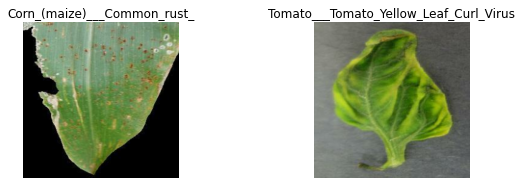

In [8]:
plt.figure(figsize=(20,20))
for image_batch,label_batch in load_data.take(1):
    for i in range(0,2):
        plt.subplot(6,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
def get_dataset_partition_tf(data,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    data_size=len(data)
    if shuffle:
        data=data.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*data_size)
    val_size=int(val_split*data_size)
    train_data=data.take(train_size)
    
    val_data=data.skip(train_size).take(val_size)
    test_data=data.skip(train_size).skip(val_size)
    return train_data,val_data,test_data
    

In [10]:
train_data,val_data,test_data=get_dataset_partition_tf(load_data)

In [11]:
len(train_data)

153

In [12]:
len(val_data)

19

In [13]:
len(test_data)

20

In [14]:
train_data=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data=val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale =tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/28)  

])

In [16]:
data_augmentation =tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)  

])

In [17]:
#for image, _ in train_ds.take(1):
 # plt.figure(figsize=(10, 10))
#  first_image = image[0]
 # for i in range(9):
  #  ax = plt.subplot(3, 3, i + 1)
   # augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    #plt.imshow(augmented_image[0] / 255)
    #plt.axis('off')

In [18]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

overall_model = models.Sequential([
    resize_and_rescale,#data_augmentation,
    layers.Conv2D(16,(3,3),activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,kernel_size = (3,3),activation= "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation= "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(len(class_names),activation='softmax')

])


In [19]:
overall_model.build(input_shape=input_shape)

In [20]:
overall_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (30, 250, 250, 3)         0         
                                                                 
 conv2d (Conv2D)             (30, 248, 248, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (30, 124, 124, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (30, 122, 122, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (30, 61, 61, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (30, 59, 59, 64)         

In [21]:
base_learning_rate = 0.0003

overall_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

In [22]:
history=overall_model.fit(
    train_data,
    epochs=20,
    batch_size=30,
    validation_data=val_data

)

Epoch 1/20
153/153 [==============================] - 106s 461ms/step - loss: 1.1673 - accuracy: 0.6750 - val_loss: 0.2900 - val_accuracy: 0.9088
Epoch 2/20
153/153 [==============================] - 26s 172ms/step - loss: 0.3328 - accuracy: 0.8856 - val_loss: 0.2459 - val_accuracy: 0.9228
Epoch 3/20
153/153 [==============================] - 22s 143ms/step - loss: 0.1923 - accuracy: 0.9356 - val_loss: 0.1655 - val_accuracy: 0.9386
Epoch 4/20
153/153 [==============================] - 20s 128ms/step - loss: 0.1237 - accuracy: 0.9605 - val_loss: 0.0844 - val_accuracy: 0.9737
Epoch 5/20
153/153 [==============================] - 14s 91ms/step - loss: 0.0726 - accuracy: 0.9756 - val_loss: 0.0883 - val_accuracy: 0.9772
Epoch 6/20
153/153 [==============================] - 11s 75ms/step - loss: 0.0746 - accuracy: 0.9786 - val_loss: 0.1526 - val_accuracy: 0.9491
Epoch 7/20
153/153 [==============================] - 12s 77ms/step - loss: 0.0467 - accuracy: 0.9863 - val_loss: 0.0472 - val_accu

In [23]:
scores=overall_model.evaluate(test_data)

20/20 [==============================] - 37s 54ms/step - loss: 0.0969 - accuracy: 0.9767


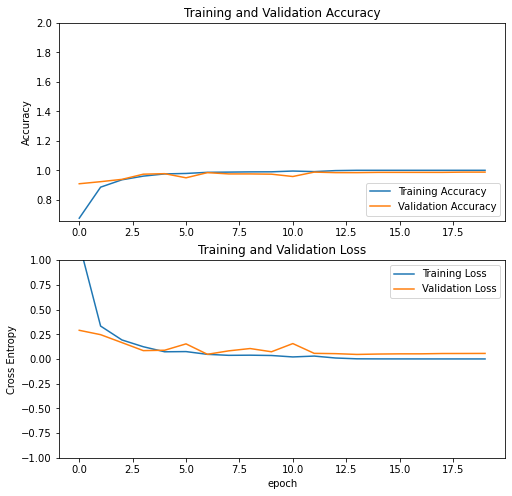

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),2])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-1,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Actual label :  Corn_(maize)___Northern_Leaf_Blight
1/1 [==============================] - 1s 832ms/step
predicted label :  Corn_(maize)___Northern_Leaf_Blight


numpy.ndarray

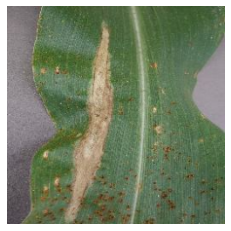

In [25]:
for image_batch,lables_batch in test_data.take(1):
    image=image_batch[0].numpy().astype("uint8")
    label=lables_batch[0].numpy()
    
    plt.imshow(image)
    print("Actual label : ",class_names[label])
    
    
    batch_prediction=overall_model.predict(image_batch)
    print("predicted label : ",class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")
type(batch_prediction[0])

In [26]:
def predict (overall_model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    prediction = overall_model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100*(np.max(prediction[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 16ms/step


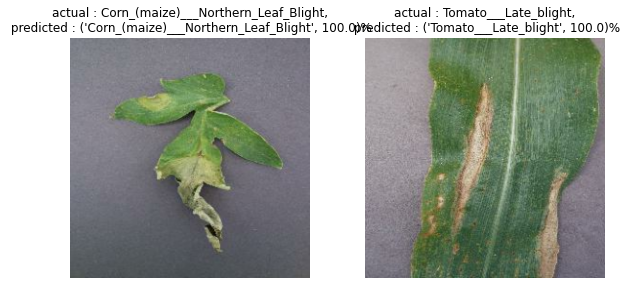

In [27]:
plt.figure(figsize=(15,15))
for image, labels in test_data.take(2):
    for i in range(2):
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.subplot(3,3,i+1)
        predicted_class= predict(overall_model,image[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"actual : {actual_class},\n predicted : {predicted_class}%")
        plt.axis("off")

In [28]:
overall_model.save("cortom.h5")

In [29]:
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from PIL import Image

# Create a Tkinter window
root = Tk()
root.withdraw()

# Open the file dialog and allow the user to choose an image file
file_path = askopenfilename(filetypes=[("Image files", "*.jpg;*.jpeg;*.png")])


In [31]:
import os

img_path = file_path
if os.path.exists(img_path):
    print("File exists!")
else:
    print("File not found.")


File exists!


In [32]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load the image
img_path = file_path
img = load_img(img_path, target_size=(250, 250))

# Convert the image to a numpy array
img_array = img_to_array(img)

# Expand the dimensions of the array to fit the model's input shape
img_array = img_array.reshape((1,) + img_array.shape)

# Load the model
model = load_model('C:/Users/user/cortom.h5')

# Make a prediction on the image
prediction = model.predict(img_array)

1/1 [==============================] - 0s 111ms/step


In [33]:
predicted_label = np.argmax(prediction)

class_names = {0:'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
               1:'Corn_(maize)___Common_rust_',
               2:'Corn_(maize)___Northern_Leaf_Blight',
               3:'Corn_(maize)___healthy',
               4:'Tomato___Late_blight',
               5:'Tomato___Septoria_leaf_spot',
               6:'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
               7:'Tomato___Tomato_mosaic_virus',
               8:'Tomato___healthy'} 
predicted_class = class_names[predicted_label]
print (predicted_class)

Tomato___Late_blight
